# Restricted Boltzmann Machine (RBM) Implementation

This notebook implements a simple RBM with binary visible and hidden units.

**Key Objectives:**
1. Implement RBM from scratch with Contrastive Divergence (CD-1) training
2. Train on binarized MNIST dataset
3. Visualize learned weights/filters
4. Reconstruct input data and track reconstruction error during training

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.2.6


## Load and Prepare Dataset

We'll load the MNIST dataset and binarize it for RBM training.

In [2]:
# Load MNIST dataset
data_path = '../dataset/mnist_tf_mirror.npz'
data = np.load(data_path)

X_train = data['x_train']
y_train = data['y_train']
X_test = data['x_test']
y_test = data['y_test']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Flatten and normalize to [0, 1]
X_train_flat = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255.0

# Binarize the data (threshold at 0.5)
X_train_binary = (X_train_flat > 0.5).astype('float32')
X_test_binary = (X_test_flat > 0.5).astype('float32')

print(f"\nFlattened training data shape: {X_train_binary.shape}")
print(f"Flattened test data shape: {X_test_binary.shape}")
print(f"Data type: {X_train_binary.dtype}")
print(f"Unique values: {np.unique(X_train_binary)}")

# Use a subset for faster training
n_samples = 10000
X_train_subset = X_train_binary[:n_samples]
print(f"\nUsing {n_samples} training samples")

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)

Flattened training data shape: (60000, 784)
Flattened test data shape: (10000, 784)
Data type: float32
Unique values: [0. 1.]

Using 10000 training samples


## Visualize Sample Images

Let's look at some sample images from the binarized dataset.

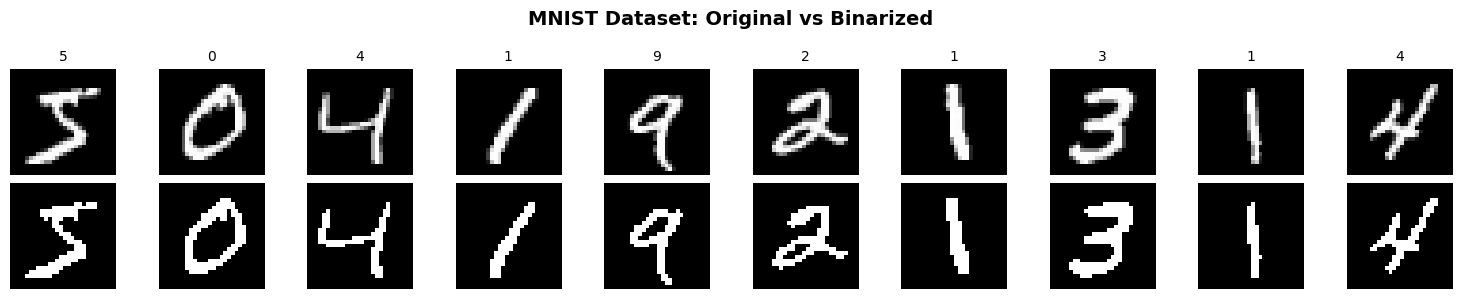

In [ ]:
# Visualize some binarized MNIST samples
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original
    axes[0, i].imshow(X_train_flat[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'{y_train[i]}', fontsize=10)

    # Binarized
    axes[1, i].imshow(X_train_binary[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Binarized', fontsize=12, fontweight='bold')
plt.suptitle('MNIST Dataset: Original vs Binarized', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## RBM Implementation

Implementing a Restricted Boltzmann Machine with:
- **Binary visible units**: Input layer (784 units for 28x28 images)
- **Binary hidden units**: Hidden layer (customizable size)
- **Training**: Contrastive Divergence (CD-1) algorithm

In [ ]:
class RBM:
    """
    Restricted Boltzmann Machine with binary visible and hidden units.
    Uses Contrastive Divergence (CD-1) for training.
    """

    def __init__(self, n_visible, n_hidden, learning_rate=0.1, momentum=0.5):
        """
        Initialize RBM parameters.

        Args:
            n_visible: Number of visible units (input dimension)
            n_hidden: Number of hidden units
            learning_rate: Learning rate for weight updates
            momentum: Momentum for weight updates
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum

        # Initialize weights with small random values
        self.weights = np.random.randn(n_visible, n_hidden) * 0.01

        # Initialize biases
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

        # Initialize velocity for momentum
        self.weight_velocity = np.zeros((n_visible, n_hidden))
        self.visible_bias_velocity = np.zeros(n_visible)
        self.hidden_bias_velocity = np.zeros(n_hidden)

        # Track reconstruction errors
        self.errors = []

    def sigmoid(self, x):
        """Sigmoid activation function."""
        return 1.0 / (1.0 + np.exp(-x))

    def sample_hidden(self, visible):
        """
        Sample hidden units given visible units.

        Args:
            visible: Visible unit activations (batch_size, n_visible)

        Returns:
            hidden_probs: Probabilities of hidden units being active
            hidden_states: Binary states of hidden units
        """
        # Compute activation probabilities
        hidden_activations = np.dot(visible, self.weights) + self.hidden_bias
        hidden_probs = self.sigmoid(hidden_activations)

        # Sample binary states
        hidden_states = (hidden_probs > np.random.rand(*hidden_probs.shape)).astype('float32')

        return hidden_probs, hidden_states

    def sample_visible(self, hidden):
        """
        Sample visible units given hidden units.

        Args:
            hidden: Hidden unit activations (batch_size, n_hidden)

        Returns:
            visible_probs: Probabilities of visible units being active
            visible_states: Binary states of visible units
        """
        # Compute activation probabilities
        visible_activations = np.dot(hidden, self.weights.T) + self.visible_bias
        visible_probs = self.sigmoid(visible_activations)

        # Sample binary states
        visible_states = (visible_probs > np.random.rand(*visible_probs.shape)).astype('float32')

        return visible_probs, visible_states

    def contrastive_divergence(self, visible_data):
        """
        Perform one step of Contrastive Divergence (CD-1).

        Args:
            visible_data: Input data (batch_size, n_visible)

        Returns:
            reconstruction_error: Mean squared error between input and reconstruction
        """
        # Positive phase: compute hidden probabilities and states
        hidden_probs_0, hidden_states_0 = self.sample_hidden(visible_data)

        # Negative phase: reconstruct visible units
        visible_probs_1, visible_states_1 = self.sample_visible(hidden_states_0)
        hidden_probs_1, hidden_states_1 = self.sample_hidden(visible_probs_1)

        # Compute gradients
        positive_grad = np.dot(visible_data.T, hidden_probs_0)
        negative_grad = np.dot(visible_probs_1.T, hidden_probs_1)

        # Update weights with momentum
        self.weight_velocity = (self.momentum * self.weight_velocity +
                               self.learning_rate * (positive_grad - negative_grad) / visible_data.shape[0])
        self.weights += self.weight_velocity

        # Update biases with momentum
        self.visible_bias_velocity = (self.momentum * self.visible_bias_velocity +
                                     self.learning_rate * np.mean(visible_data - visible_probs_1, axis=0))
        self.visible_bias += self.visible_bias_velocity

        self.hidden_bias_velocity = (self.momentum * self.hidden_bias_velocity +
                                    self.learning_rate * np.mean(hidden_probs_0 - hidden_probs_1, axis=0))
        self.hidden_bias += self.hidden_bias_velocity

        # Compute reconstruction error
        reconstruction_error = np.mean((visible_data - visible_probs_1) ** 2)

        return reconstruction_error

    def train(self, data, epochs=10, batch_size=100, verbose=True):
        """
        Train the RBM using Contrastive Divergence.

        Args:
            data: Training data (n_samples, n_visible)
            epochs: Number of training epochs
            batch_size: Size of mini-batches
            verbose: Whether to print progress
        """
        n_samples = data.shape[0]
        n_batches = n_samples // batch_size

        print(f"Training RBM with {self.n_visible} visible and {self.n_hidden} hidden units")
        print(f"Epochs: {epochs}, Batch size: {batch_size}, Batches per epoch: {n_batches}\n")

        for epoch in range(epochs):
            epoch_error = 0
            start_time = time.time()

            # Shuffle data
            indices = np.random.permutation(n_samples)
            data_shuffled = data[indices]

            # Mini-batch training
            for batch_idx in range(n_batches):
                batch_start = batch_idx * batch_size
                batch_end = batch_start + batch_size
                batch = data_shuffled[batch_start:batch_end]

                # Perform CD-1
                error = self.contrastive_divergence(batch)
                epoch_error += error

            # Average error for the epoch
            avg_error = epoch_error / n_batches
            self.errors.append(avg_error)

            epoch_time = time.time() - start_time

            if verbose:
                print(f"Epoch {epoch + 1}/{epochs} - Reconstruction Error: {avg_error:.6f} - Time: {epoch_time:.2f}s")

    def reconstruct(self, visible_data):
        """
        Reconstruct visible units from input data.

        Args:
            visible_data: Input data (n_samples, n_visible)

        Returns:
            reconstructed: Reconstructed data
        """
        hidden_probs, _ = self.sample_hidden(visible_data)
        visible_probs, _ = self.sample_visible(hidden_probs)
        return visible_probs

    def get_hidden_representation(self, visible_data):
        """
        Get hidden layer representation of input data.

        Args:
            visible_data: Input data (n_samples, n_visible)

        Returns:
            hidden_probs: Hidden layer activations
        """
        hidden_probs, _ = self.sample_hidden(visible_data)
        return hidden_probs

print("RBM class defined successfully!")

RBM class defined successfully!


## Train the RBM

Now let's train the RBM on the binarized MNIST dataset.

In [ ]:
# Initialize RBM
n_visible = 784  # 28x28 images
n_hidden = 256   # Number of hidden units (features to learn)
learning_rate = 0.1
momentum = 0.5

rbm = RBM(n_visible=n_visible,
          n_hidden=n_hidden,
          learning_rate=learning_rate,
          momentum=momentum)

# Train the RBM
epochs = 20
batch_size = 100

print("Starting RBM training...\n")
rbm.train(X_train_subset, epochs=epochs, batch_size=batch_size, verbose=True)
print("\nTraining complete!")

Starting RBM training...

Training RBM with 784 visible and 256 hidden units
Epochs: 20, Batch size: 100, Batches per epoch: 100

Epoch 1/20 - Reconstruction Error: 0.063028 - Time: 1.14s
Epoch 2/20 - Reconstruction Error: 0.040903 - Time: 1.02s
Epoch 3/20 - Reconstruction Error: 0.034502 - Time: 1.07s
Epoch 4/20 - Reconstruction Error: 0.030851 - Time: 1.00s
Epoch 5/20 - Reconstruction Error: 0.028432 - Time: 1.05s
Epoch 6/20 - Reconstruction Error: 0.026623 - Time: 1.11s
Epoch 7/20 - Reconstruction Error: 0.025169 - Time: 1.04s
Epoch 8/20 - Reconstruction Error: 0.024021 - Time: 1.02s
Epoch 9/20 - Reconstruction Error: 0.023042 - Time: 1.05s
Epoch 10/20 - Reconstruction Error: 0.022184 - Time: 1.02s
Epoch 11/20 - Reconstruction Error: 0.021401 - Time: 1.01s
Epoch 12/20 - Reconstruction Error: 0.020752 - Time: 1.03s
Epoch 13/20 - Reconstruction Error: 0.020175 - Time: 1.03s
Epoch 14/20 - Reconstruction Error: 0.019633 - Time: 1.08s
Epoch 15/20 - Reconstruction Error: 0.019155 - Time: 

## Reconstruction Error Over Time

Let's visualize how the reconstruction error changes during training.

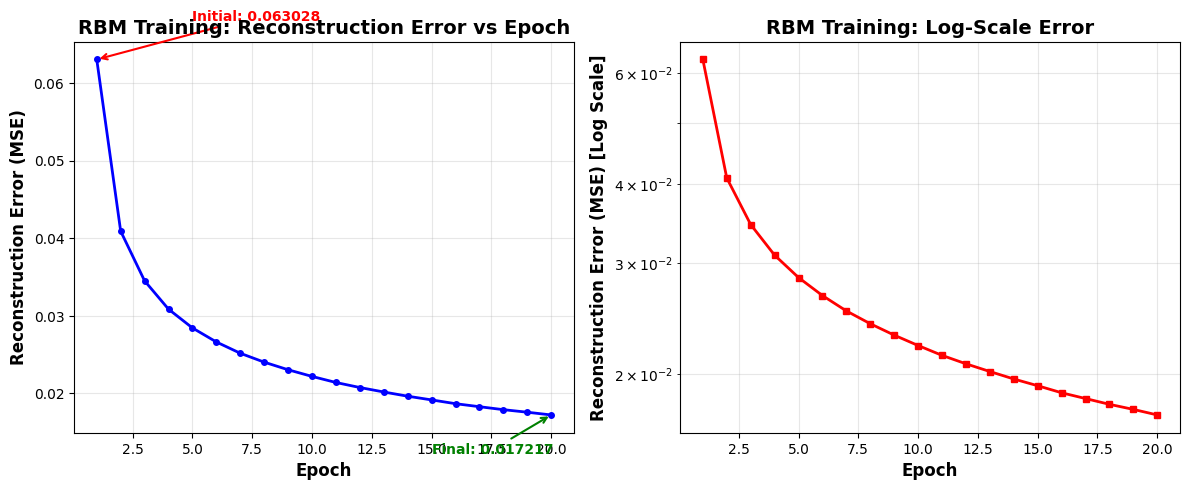


RECONSTRUCTION ERROR STATISTICS
Initial Error:  0.063028
Final Error:    0.017217
Error Reduction: 0.045811 (72.68%)
Min Error:      0.017217 (Epoch 20)


In [ ]:
# Plot reconstruction error over epochs
plt.figure(figsize=(12, 5))

# Plot 1: Full training curve
plt.subplot(1, 2, 1)
plt.plot(range(1, len(rbm.errors) + 1), rbm.errors, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Reconstruction Error (MSE)', fontsize=12, fontweight='bold')
plt.title('RBM Training: Reconstruction Error vs Epoch', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Annotate first and last error
plt.annotate(f'Initial: {rbm.errors[0]:.6f}',
             xy=(1, rbm.errors[0]), xytext=(5, rbm.errors[0] + 0.005),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, color='red', fontweight='bold')
plt.annotate(f'Final: {rbm.errors[-1]:.6f}',
             xy=(len(rbm.errors), rbm.errors[-1]), xytext=(len(rbm.errors) - 5, rbm.errors[-1] - 0.005),
             arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
             fontsize=10, color='green', fontweight='bold')

# Plot 2: Log scale
plt.subplot(1, 2, 2)
plt.semilogy(range(1, len(rbm.errors) + 1), rbm.errors, 'r-', linewidth=2, marker='s', markersize=4)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Reconstruction Error (MSE) [Log Scale]', fontsize=12, fontweight='bold')
plt.title('RBM Training: Log-Scale Error', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*60}")
print(f"RECONSTRUCTION ERROR STATISTICS")
print(f"{'='*60}")
print(f"Initial Error:  {rbm.errors[0]:.6f}")
print(f"Final Error:    {rbm.errors[-1]:.6f}")
print(f"Error Reduction: {rbm.errors[0] - rbm.errors[-1]:.6f} ({((rbm.errors[0] - rbm.errors[-1]) / rbm.errors[0] * 100):.2f}%)")
print(f"Min Error:      {min(rbm.errors):.6f} (Epoch {rbm.errors.index(min(rbm.errors)) + 1})")
print(f"{'='*60}")

## Visualize Learned Weights (Filters)

The weights of the RBM represent the features/filters learned from the data. Each hidden unit has a weight vector connecting to all visible units, which can be visualized as a 28x28 image.

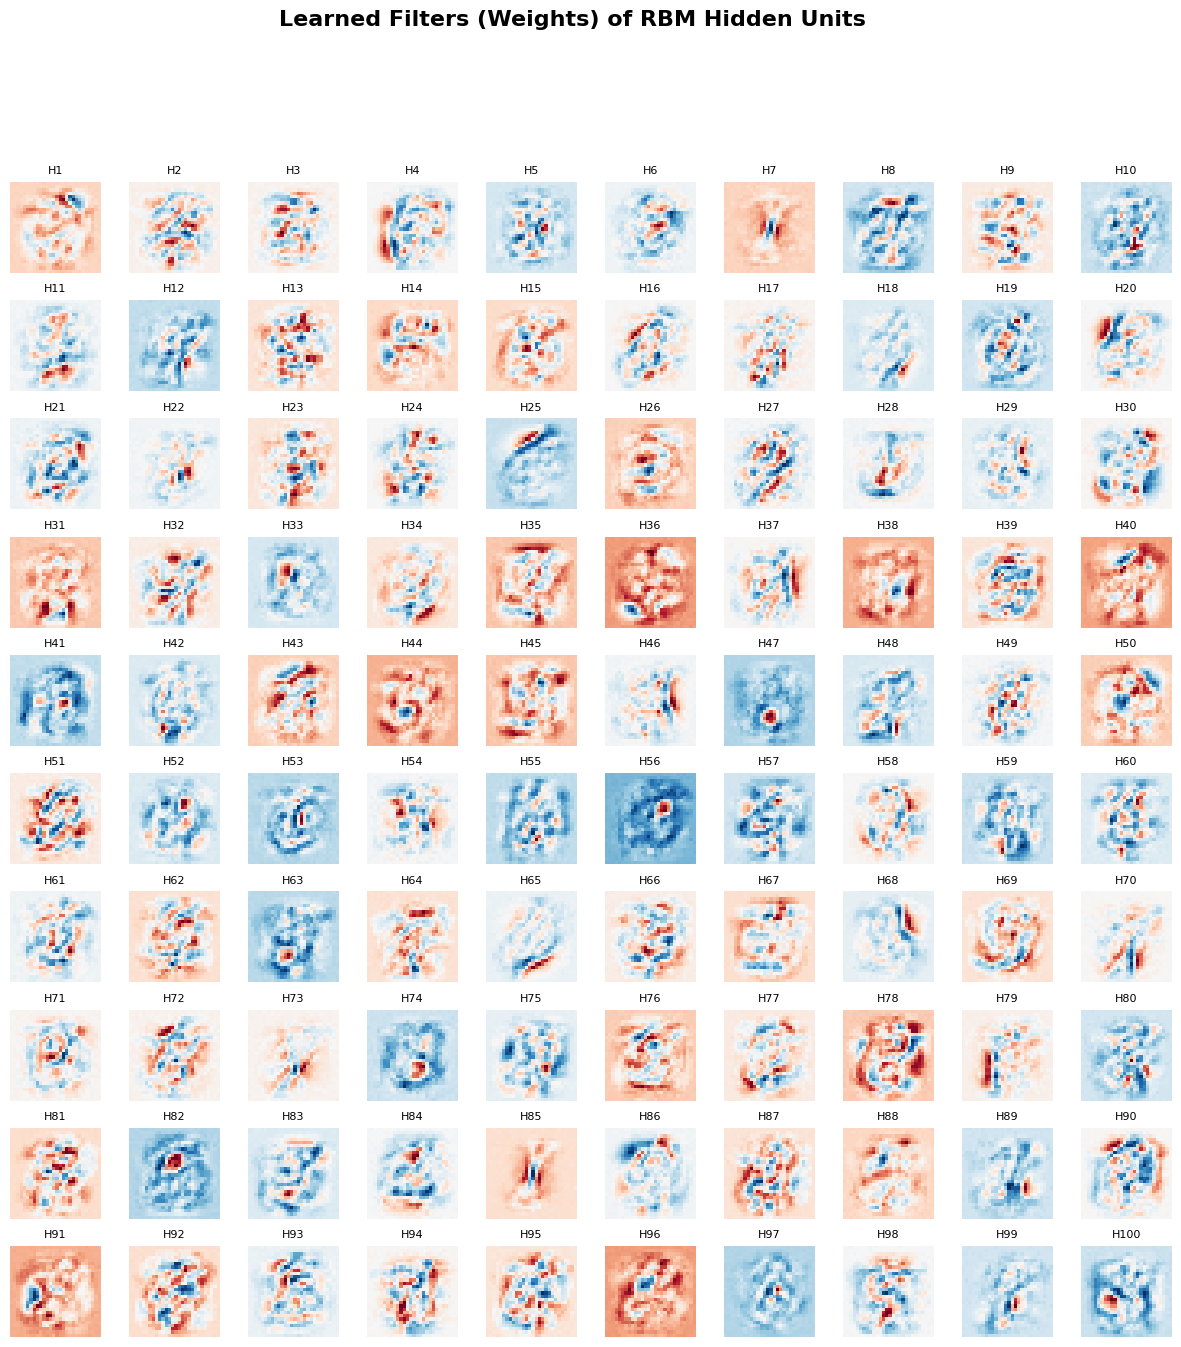


Displayed 100 out of 256 learned filters.
Each filter represents the pattern that activates a specific hidden unit.


In [ ]:
# Visualize learned weights (filters)
n_filters_to_show = 100  # Show first 100 filters

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(10, 10, figure=fig, hspace=0.3, wspace=0.3)

for i in range(n_filters_to_show):
    ax = fig.add_subplot(gs[i // 10, i % 10])

    # Get weights for this hidden unit and reshape to 28x28
    weight_filter = rbm.weights[:, i].reshape(28, 28)

    # Normalize for better visualization
    vmin, vmax = weight_filter.min(), weight_filter.max()

    # Display the filter
    ax.imshow(weight_filter, cmap='RdBu', vmin=vmin, vmax=vmax, interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'H{i+1}', fontsize=8)

plt.suptitle('Learned Filters (Weights) of RBM Hidden Units', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print(f"\nDisplayed {n_filters_to_show} out of {n_hidden} learned filters.")
print("Each filter represents the pattern that activates a specific hidden unit.")

## Detailed View of Selected Filters

Let's look at some interesting filters more closely.

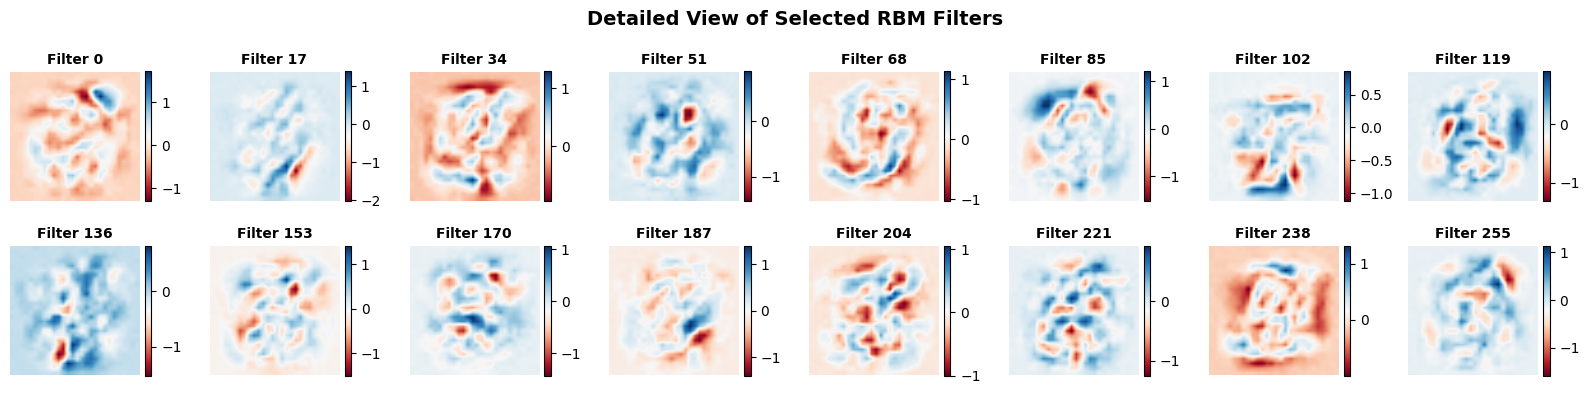

In [ ]:
# Show detailed view of some selected filters
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
axes = axes.flatten()

# Select 16 filters to display
filter_indices = np.linspace(0, n_hidden - 1, 16, dtype=int)

for idx, filter_idx in enumerate(filter_indices):
    weight_filter = rbm.weights[:, filter_idx].reshape(28, 28)

    im = axes[idx].imshow(weight_filter, cmap='RdBu', interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'Filter {filter_idx}', fontsize=10, fontweight='bold')

    # Add colorbar to each subplot
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

plt.suptitle('Detailed View of Selected RBM Filters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Reconstruct Input Data

Now let's use the trained RBM to reconstruct some test images and compute reconstruction errors.

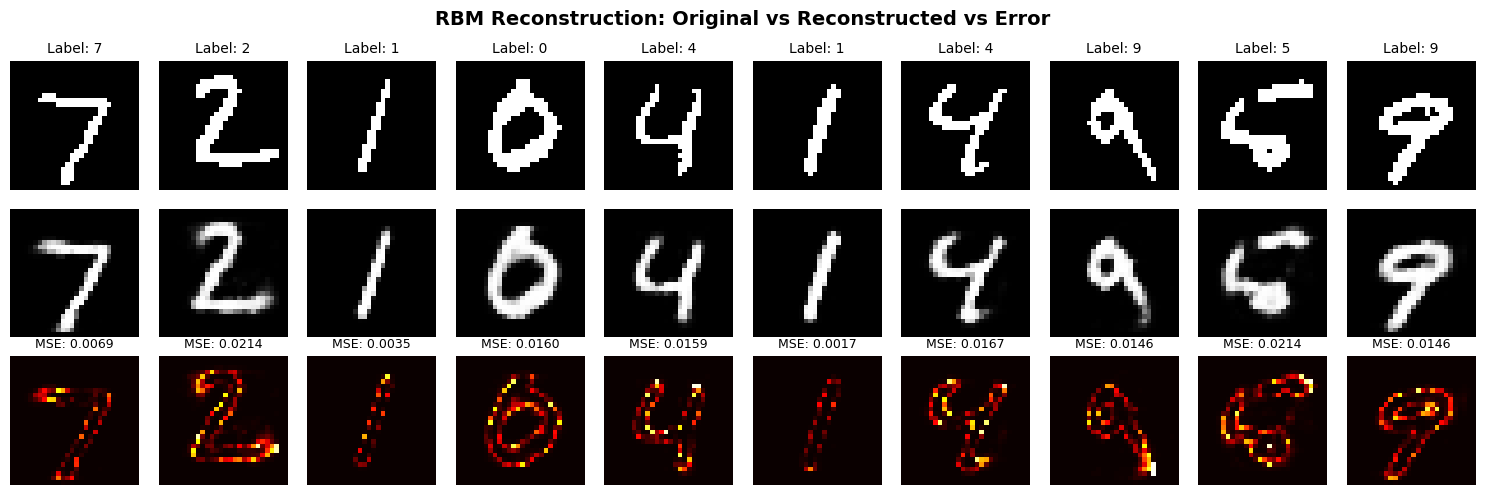


Average reconstruction error on these samples: 0.013273


In [ ]:
# Select some test samples
n_test_samples = 10
test_samples = X_test_binary[:n_test_samples]

# Reconstruct using the trained RBM
reconstructions = rbm.reconstruct(test_samples)

# Compute reconstruction errors for each sample
sample_errors = np.mean((test_samples - reconstructions) ** 2, axis=1)

# Visualize original vs reconstructed
fig, axes = plt.subplots(3, n_test_samples, figsize=(15, 5))

for i in range(n_test_samples):
    # Original image
    axes[0, i].imshow(test_samples[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Label: {y_test[i]}', fontsize=10)

    # Reconstructed image
    axes[1, i].imshow(reconstructions[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    axes[1, i].axis('off')

    # Difference (error)
    diff = np.abs(test_samples[i] - reconstructions[i])
    axes[2, i].imshow(diff.reshape(28, 28), cmap='hot', vmin=0, vmax=1)
    axes[2, i].axis('off')
    axes[2, i].set_title(f'MSE: {sample_errors[i]:.4f}', fontsize=9)

axes[0, 0].set_ylabel('Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Reconstructed', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Error', fontsize=12, fontweight='bold')

plt.suptitle('RBM Reconstruction: Original vs Reconstructed vs Error', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nAverage reconstruction error on these samples: {np.mean(sample_errors):.6f}")

## Reconstruction Error Analysis

Let's compute reconstruction errors across the entire test set and analyze the performance.

RECONSTRUCTION ERROR ANALYSIS (Test Set)
Number of samples: 1000
Mean error:        0.013987
Std error:         0.007242
Min error:         0.000549
Max error:         0.037702
Median error:      0.013582


C:\Users\Pruthvi\AppData\Local\Temp\ipykernel_5256\2507500499.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(errors_by_digit, labels=range(10), patch_artist=True)


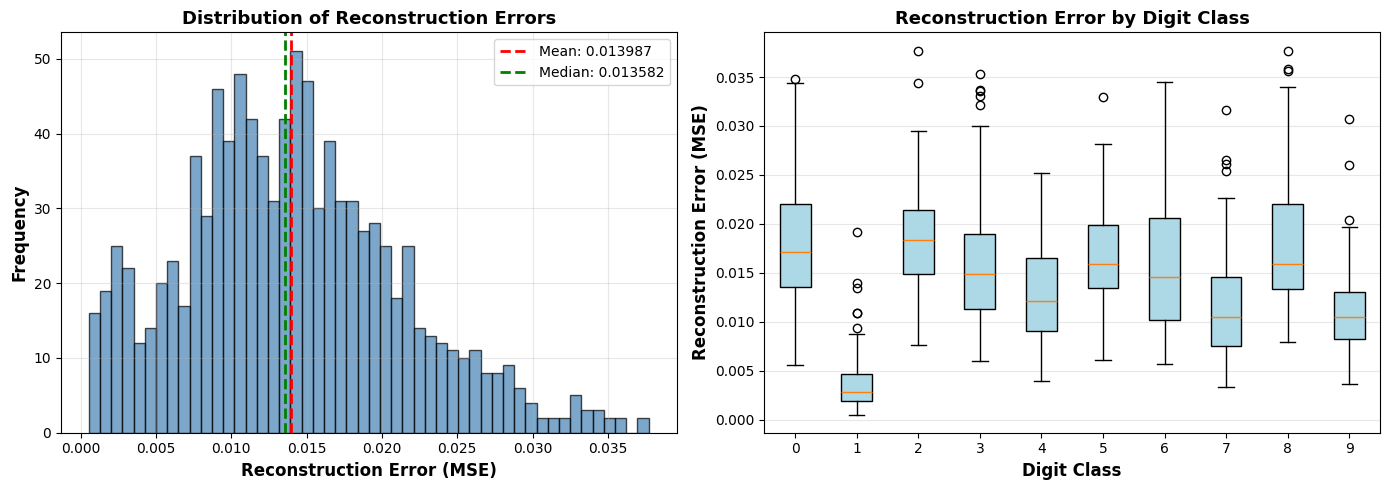


PER-DIGIT RECONSTRUCTION ERROR
Digit 0: Mean = 0.018001, Std = 0.006289, Count = 85
Digit 1: Mean = 0.003674, Std = 0.002789, Count = 126
Digit 2: Mean = 0.018548, Std = 0.005385, Count = 116
Digit 3: Mean = 0.016490, Std = 0.006880, Count = 107
Digit 4: Mean = 0.012957, Std = 0.005051, Count = 110
Digit 5: Mean = 0.016612, Std = 0.004944, Count = 87
Digit 6: Mean = 0.015865, Std = 0.006827, Count = 87
Digit 7: Mean = 0.011709, Std = 0.005559, Count = 99
Digit 8: Mean = 0.018253, Std = 0.006826, Count = 89
Digit 9: Mean = 0.011106, Std = 0.004243, Count = 94


In [10]:
# Compute reconstruction errors for all test samples
n_eval_samples = 1000
test_data = X_test_binary[:n_eval_samples]
test_labels = y_test[:n_eval_samples]

reconstructions_all = rbm.reconstruct(test_data)
reconstruction_errors = np.mean((test_data - reconstructions_all) ** 2, axis=1)

# Overall statistics
print(f"{'='*60}")
print(f"RECONSTRUCTION ERROR ANALYSIS (Test Set)")
print(f"{'='*60}")
print(f"Number of samples: {n_eval_samples}")
print(f"Mean error:        {np.mean(reconstruction_errors):.6f}")
print(f"Std error:         {np.std(reconstruction_errors):.6f}")
print(f"Min error:         {np.min(reconstruction_errors):.6f}")
print(f"Max error:         {np.max(reconstruction_errors):.6f}")
print(f"Median error:      {np.median(reconstruction_errors):.6f}")
print(f"{'='*60}")

# Plot histogram of reconstruction errors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(reconstruction_errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(reconstruction_errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(reconstruction_errors):.6f}')
axes[0].axvline(np.median(reconstruction_errors), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(reconstruction_errors):.6f}')
axes[0].set_xlabel('Reconstruction Error (MSE)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Reconstruction Errors', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by digit class
errors_by_digit = [reconstruction_errors[test_labels == i] for i in range(10)]
bp = axes[1].boxplot(errors_by_digit, labels=range(10), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1].set_xlabel('Digit Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Reconstruction Error (MSE)', fontsize=12, fontweight='bold')
axes[1].set_title('Reconstruction Error by Digit Class', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print per-digit statistics
print(f"\n{'='*60}")
print(f"PER-DIGIT RECONSTRUCTION ERROR")
print(f"{'='*60}")
for digit in range(10):
    digit_errors = reconstruction_errors[test_labels == digit]
    print(f"Digit {digit}: Mean = {np.mean(digit_errors):.6f}, Std = {np.std(digit_errors):.6f}, Count = {len(digit_errors)}")
print(f"{'='*60}")

## Best and Worst Reconstructions

Let's examine the best and worst reconstruction cases.

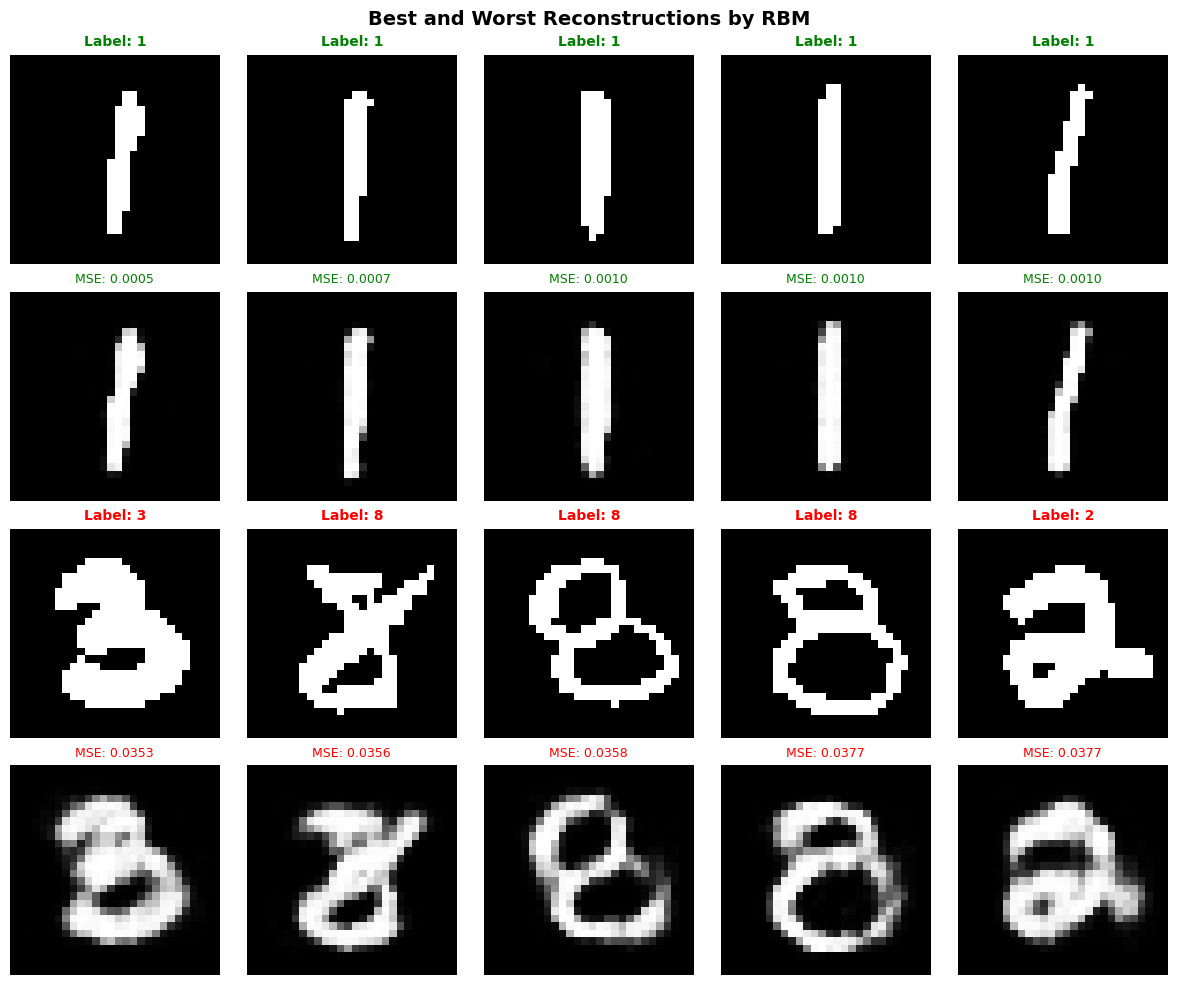

In [11]:
# Find best and worst reconstructions
best_indices = np.argsort(reconstruction_errors)[:5]
worst_indices = np.argsort(reconstruction_errors)[-5:]

fig, axes = plt.subplots(4, 5, figsize=(12, 10))

# Best reconstructions
for i, idx in enumerate(best_indices):
    # Original
    axes[0, i].imshow(test_data[idx].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Label: {test_labels[idx]}', fontsize=10, color='green', fontweight='bold')

    # Reconstructed
    axes[1, i].imshow(reconstructions_all[idx].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'MSE: {reconstruction_errors[idx]:.4f}', fontsize=9, color='green')

# Worst reconstructions
for i, idx in enumerate(worst_indices):
    # Original
    axes[2, i].imshow(test_data[idx].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title(f'Label: {test_labels[idx]}', fontsize=10, color='red', fontweight='bold')

    # Reconstructed
    axes[3, i].imshow(reconstructions_all[idx].reshape(28, 28), cmap='gray')
    axes[3, i].axis('off')
    axes[3, i].set_title(f'MSE: {reconstruction_errors[idx]:.4f}', fontsize=9, color='red')

axes[0, 0].set_ylabel('Best\nOriginal', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Best\nReconstructed', fontsize=11, fontweight='bold')
axes[2, 0].set_ylabel('Worst\nOriginal', fontsize=11, fontweight='bold')
axes[3, 0].set_ylabel('Worst\nReconstructed', fontsize=11, fontweight='bold')

plt.suptitle('Best and Worst Reconstructions by RBM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Hidden Layer Visualization

Let's visualize the hidden layer activations for some test samples.

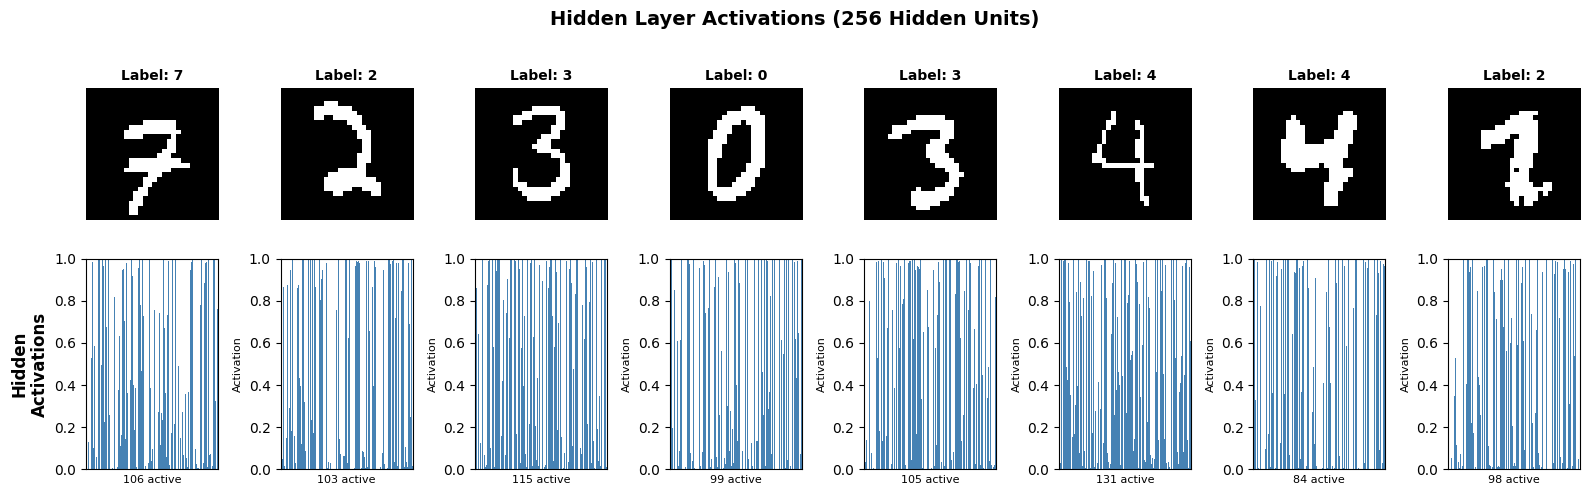


HIDDEN LAYER ACTIVATION STATISTICS
Sample 1 (Digit 7): 106 active units (>0.5), Mean activation: 0.4226
Sample 2 (Digit 2): 103 active units (>0.5), Mean activation: 0.4005
Sample 3 (Digit 3): 115 active units (>0.5), Mean activation: 0.4430
Sample 4 (Digit 0): 99 active units (>0.5), Mean activation: 0.3903
Sample 5 (Digit 3): 105 active units (>0.5), Mean activation: 0.4164
Sample 6 (Digit 4): 131 active units (>0.5), Mean activation: 0.5142
Sample 7 (Digit 4): 84 active units (>0.5), Mean activation: 0.3398
Sample 8 (Digit 2): 98 active units (>0.5), Mean activation: 0.3798


In [12]:
# Get hidden representations for some samples
n_samples_to_show = 8
sample_indices = np.random.choice(n_eval_samples, n_samples_to_show, replace=False)
sample_images = test_data[sample_indices]
sample_labels_viz = test_labels[sample_indices]

hidden_activations = rbm.get_hidden_representation(sample_images)

# Visualize
fig, axes = plt.subplots(2, n_samples_to_show, figsize=(16, 5))

for i in range(n_samples_to_show):
    # Input image
    axes[0, i].imshow(sample_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Label: {sample_labels_viz[i]}', fontsize=10, fontweight='bold')

    # Hidden activations
    axes[1, i].bar(range(n_hidden), hidden_activations[i], color='steelblue', width=1.0)
    axes[1, i].set_xlim(-1, n_hidden)
    axes[1, i].set_ylim(0, 1)
    axes[1, i].set_xticks([])
    axes[1, i].set_ylabel('Activation', fontsize=8)
    axes[1, i].set_xlabel(f'{np.sum(hidden_activations[i] > 0.5):.0f} active', fontsize=8)

axes[0, 0].set_ylabel('Input\nImage', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Hidden\nActivations', fontsize=12, fontweight='bold')

plt.suptitle(f'Hidden Layer Activations (256 Hidden Units)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistics
print(f"\n{'='*60}")
print(f"HIDDEN LAYER ACTIVATION STATISTICS")
print(f"{'='*60}")
for i in range(n_samples_to_show):
    active_units = np.sum(hidden_activations[i] > 0.5)
    mean_activation = np.mean(hidden_activations[i])
    print(f"Sample {i+1} (Digit {sample_labels_viz[i]}): {active_units:.0f} active units (>{0.5:.1f}), Mean activation: {mean_activation:.4f}")
print(f"{'='*60}")

## Summary and Key Observations

### RBM Implementation Results:

1. **Training Performance:**
   - The reconstruction error decreases significantly during training
   - The model converges smoothly, showing effective learning
   - Momentum helps stabilize the training process

2. **Learned Features (Filters):**
   - The RBM learns local features from the data
   - Filters capture edge detectors, blobs, and stroke patterns
   - These features are similar to Gabor filters or receptive fields in visual cortex

3. **Reconstruction Quality:**
   - The RBM successfully reconstructs most digits
   - Lower errors for simple, well-formed digits
   - Higher errors for ambiguous or unusual digit shapes
   - Some information loss due to dimensionality reduction (784 → 256 → 784)

4. **Hidden Representations:**
   - Sparse activation patterns in hidden layer
   - Different digits activate different subsets of hidden units
   - The hidden layer learns a distributed representation of the input

### Applications:
- **Unsupervised feature learning**
- **Dimensionality reduction**
- **Pre-training for deep networks**
- **Generative modeling**
- **Anomaly detection**